In [1]:
import pandas as pd
import numpy as np
import googlemaps
from datetime import datetime
import acquire_r
from env import google_key
from googlemaps import convert
import wrangle_zillow_r
import wrangle_zillow
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [17]:
#df = acquire_r.get_zillow_data()
# df1 = df1.dropna()

In [2]:
df.to_csv('zillow.csv')

NameError: name 'df' is not defined

In [28]:
zillow = pd.read_csv('zillow.csv')

In [35]:
single_use = [261, 262, 263, 264, 266, 268, 273, 276, 279]
zillow = zillow[zillow.propertylandusetypeid.isin(single_use)]

In [41]:
zillow = zillow[(zillow.bedroomcnt > 0) & (zillow.bathroomcnt > 0) & ((df.unitcnt<=1)|df.unitcnt.isnull())]

In [42]:
zillow.unitcnt.value_counts()

1.0    45166
Name: unitcnt, dtype: int64

In [45]:
zillow.fips.value_counts()

6037.0    45326
6059.0    20296
6111.0     5748
Name: fips, dtype: int64

In [46]:
zillow['county'] = np.where(zillow.fips == 6037, 'Los_Angeles',
                            np.where(zillow.fips == 6059, 'Orange', 'Ventura'))

In [47]:
zillow['regionidzip'] = zillow['regionidzip'].replace(399675, 99675)

In [48]:
zillow = wrangle_zillow_r.zillow_impute_knn(zillow)

In [49]:
zillow = wrangle_zillow_r.add_zip_income(zillow)

In [50]:
def fill_nulls_with_zero(df, col_names):
    for col in col_names:
        df[col] = df[col].fillna(0)
    return df

In [51]:
# Test function
null_cols = ['airconditioningtypeid', 'basementsqft', 'decktypeid',
             'fireplacecnt', 'garagecarcnt', 'garagetotalsqft',
             'hashottuborspa', 'lotsizesquarefeet', 'poolcnt',
             'poolsizesum', 'taxdelinquencyyear']

zillow = fill_nulls_with_zero(zillow, null_cols)

In [52]:
# Heatingorsystemtypeid - None type is 13
# Assume number of stories is 1
# Assume unitcnt is 1

def handle_other_nulls(df):
    df.heatingorsystemtypeid.fillna(13, inplace=True)
    df.numberofstories.fillna(1, inplace=True)
    df.unitcnt.fillna(1, inplace=True)
    return df

In [53]:
zillow = handle_other_nulls(zillow)

In [54]:
zillow.isnull().sum().sort_values(ascending = False)

finishedsquarefeet13    73638
buildingclasstypeid     73638
buildingclassdesc       73638
finishedsquarefeet15    73629
storytypeid             73591
                        ...  
poolsizesum                 0
poolcnt                     0
lotsizesquarefeet           0
longitude                   0
Unnamed: 0                  0
Length: 73, dtype: int64

In [56]:
zillow = wrangle_zillow.remove_columns(zillow, 
                                       ['parcelid',
                                        'architecturalstyletypeid',
                                        'buildingclasstypeid',
                                        'finishedsquarefeet13',
                                        'finishedsquarefeet15',
                                        'finishedsquarefeet50',
                                        'finishedsquarefeet6',
                                        'finishedfloor1squarefeet',
                                        'pooltypeid10',
                                        'pooltypeid2',
                                        'pooltypeid7',
                                        'fireplaceflag',
                                        'airconditioningdesc',
                                        'storydesc',
                                        'heatingorsystemdesc',
                                        'architecturalstyledesc',
                                        'buildingclassdesc',
                                        'typeconstructiondesc',
                                        'yardbuildingsqft17',
                                        'yardbuildingsqft26',
                                        'calculatedbathnbr',
                                        'fullbathcnt',
                                        'threequarterbathnbr',
                                        'typeconstructiontypeid',
                                        'storytypeid',
                                        'propertyzoningdesc', 
                                        'calculatedfinishedsquarefeet', 
                                        'regionidneighborhood',
                                        'regionidcity',
                                        'regionidcounty',
                                        'propertylandusetypeid',
                                        'rawcensustractandblock',
                                        'propertylandusedesc',
                                        'assessmentyear'])

In [60]:
zillow.isnull().sum().sort_values(ascending = False)

finishedsquarefeet12          177
structuretaxvaluedollarcnt    103
yearbuilt                      42
taxamount                       5
landtaxvaluedollarcnt           1
taxvaluedollarcnt               1
heatingorsystemtypeid           0
hashottuborspa                  0
garagetotalsqft                 0
garagecarcnt                    0
fireplacecnt                    0
fips                            0
median_income                   0
longitude                       0
decktypeid                      0
bedroomcnt                      0
bathroomcnt                     0
basementsqft                    0
airconditioningtypeid           0
id                              0
latitude                        0
poolsizesum                     0
lotsizesquarefeet               0
poolcnt                         0
new_zip                         0
propertycountylandusecode       0
roomcnt                         0
unitcnt                         0
numberofstories                 0
taxdelinquency

In [59]:
zillow = zillow.drop(columns = ['taxdelinquencyflag', 'buildingqualitytypeid'])

In [61]:

def zillow_imputer(df):
    num_vars = list(df.select_dtypes('number').columns)
    imp = IterativeImputer(random_state=423)
    imp.fit(df[num_vars])
    df[num_vars] = imp.transform(df[num_vars])
    return df

In [64]:
zillow = zillow_imputer(zillow)

median_income                 0
poolcnt                       0
longitude                     0
latitude                      0
heatingorsystemtypeid         0
hashottuborspa                0
garagetotalsqft               0
garagecarcnt                  0
fireplacecnt                  0
fips                          0
finishedsquarefeet12          0
decktypeid                    0
bedroomcnt                    0
bathroomcnt                   0
basementsqft                  0
airconditioningtypeid         0
id                            0
lotsizesquarefeet             0
poolsizesum                   0
new_zip                       0
propertycountylandusecode     0
census_tractandblock          0
regionid_zip                  0
haversine_distance            0
county                        0
transactiondate               0
logerror                      0
taxdelinquencyyear            0
taxamount                     0
landtaxvaluedollarcnt         0
taxvaluedollarcnt             0
structur

In [66]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73638 entries, 0 to 73637
Data columns (total 37 columns):
Unnamed: 0                    73638 non-null float64
id                            73638 non-null float64
airconditioningtypeid         73638 non-null float64
basementsqft                  73638 non-null float64
bathroomcnt                   73638 non-null float64
bedroomcnt                    73638 non-null float64
decktypeid                    73638 non-null float64
finishedsquarefeet12          73638 non-null float64
fips                          73638 non-null float64
fireplacecnt                  73638 non-null float64
garagecarcnt                  73638 non-null float64
garagetotalsqft               73638 non-null float64
hashottuborspa                73638 non-null float64
heatingorsystemtypeid         73638 non-null float64
latitude                      73638 non-null float64
longitude                     73638 non-null float64
lotsizesquarefeet             73638 non-nul

In [2]:
zillow = wrangle_zillow.wrangle_zillow()

In [3]:
#random state 539

In [19]:
zillow.new_zip.max()

854853.3290035842

In [7]:
train, test = train_test_split(zillow, train_size = .80, random_state = 539)

In [8]:
train, validate = train_test_split(train, train_size = .80, random_state = 539)

### cluster the traget variable (logerror)

In [9]:
X = train[['logerror']]

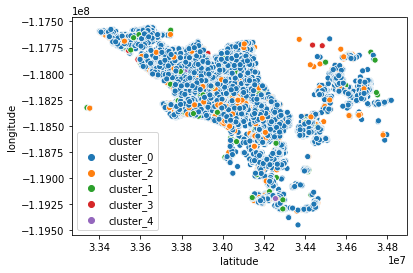

In [14]:
kmeans = KMeans(n_clusters = 5)
kmeans.fit(X)
kmeans.predict(X)
train['cluster'] = kmeans.predict(X)
train['cluster'] = 'cluster_' + train.cluster.astype(str)
sns.scatterplot(x = 'latitude', y = 'longitude', data = train, hue = 'cluster')

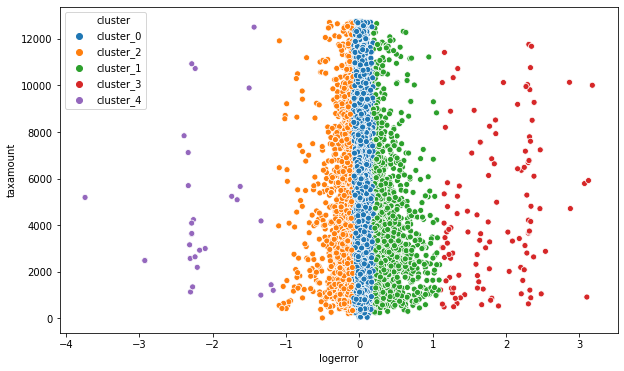

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'taxamount', data = train, hue = 'cluster')

(89000.0, 98000.0)

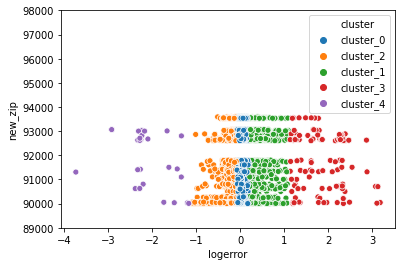

In [22]:
sns.scatterplot(x = 'logerror', y = 'new_zip', data = train, hue = 'cluster')
plt.ylim(89000, 98000)

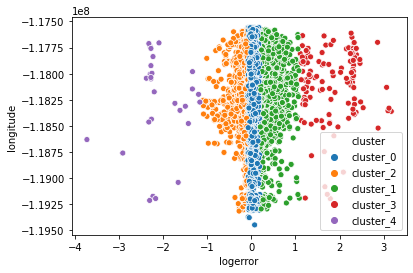

In [23]:
sns.scatterplot(x = 'logerror', y = 'longitude', data = train, hue = 'cluster')

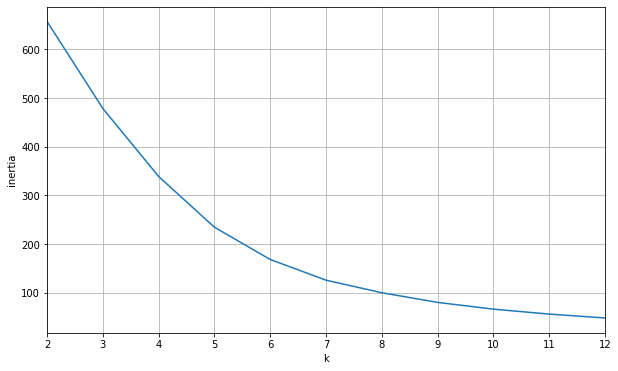

In [10]:
def get_inertia(k):
    kmeans = KMeans(k)
    kmeans.fit(X)
    return kmeans.inertia_

plt.figure(figsize=(10, 6))
pd.Series({k: get_inertia(k) for k in range(2, 13)}).plot()
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()

### Cluster Independent Variables

Location, that is, latitude and longitude\
Size (finished square feet)\
Location and size\
Be sure to use these new clusters in exploring your data, and interpret what these clusters tell you.

In [42]:
train = train.drop(columns = 'cluster')

In [53]:
X = train[['latitude', 'longitude']]

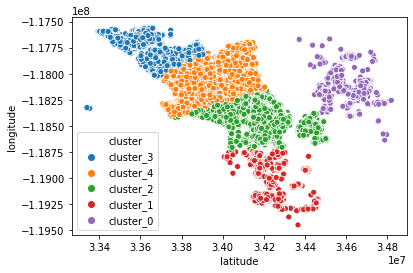

In [58]:
kmeans = KMeans(n_clusters = 5)
kmeans.fit(X)
kmeans.predict(X)
train['cluster'] = kmeans.predict(X)
train['cluster'] = 'cluster_' + train.cluster.astype(str)
sns.scatterplot(x = 'latitude', y = 'longitude', data = train, hue = 'cluster')

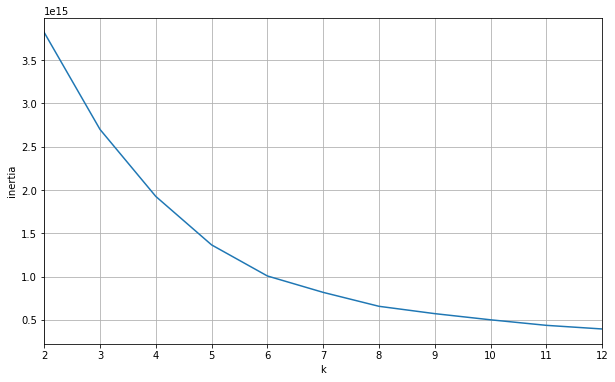

In [50]:
def get_inertia(k):
    kmeans = KMeans(k)
    kmeans.fit(X)
    return kmeans.inertia_

plt.figure(figsize=(10, 6))
pd.Series({k: get_inertia(k) for k in range(2, 13)}).plot()
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()